In [7]:
%matplotlib inline
import pandas as pd
import glob
import matplotlib.pyplot as plt

plt.style.use(['seaborn-poster', 'seaborn-white'])

In [8]:
df = pd.read_csv("data/comfort_data.csv")

qry = ["solar==0",
       "days==14",
       "strategy in ['no_control', 'smooth', 'single_bucket']"]

df = df.query(" and ".join(qry))
df.timestamp = pd.to_datetime(df.timestamp)

In [9]:
len(df.name.unique()), len(df.feeder.unique()), len(df.season.unique()), len(df.strategy.unique())

(903, 2, 2, 3)

## One instance 

In [268]:
qry = ["feeder=='one'",
       "season=='summer'",
       "strategy=='no_control'",
       "control==0",
       "attribute=='shower demand 110'"]

tmp = df.query(" and ".join(qry))

How many unique customers are impacted over the period?

In [269]:
cust = len(tmp.name.unique())
total_cust = float(tmp.num_houses.unique()[0])

print("{}%".format(cust/total_cust*100))

25.3%


Unique customer impacted per day?

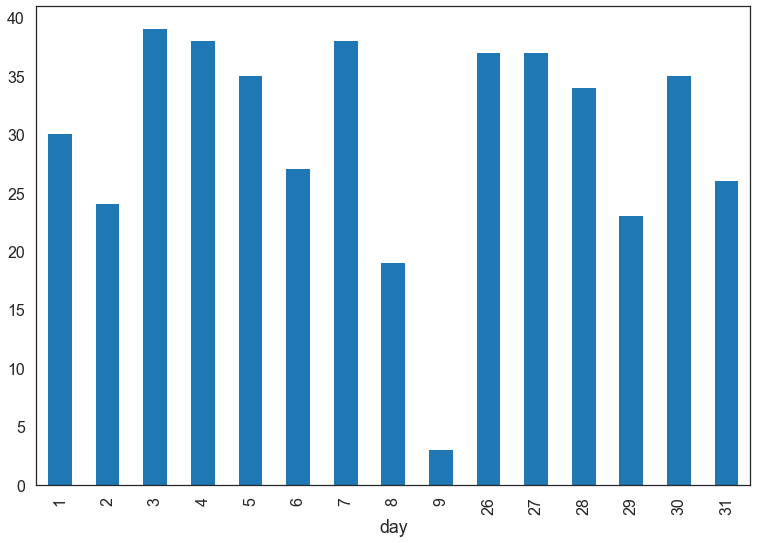

In [270]:
piv = tmp.pivot_table(index='name', columns='day', values='value', aggfunc='count')
grp = tmp.groupby(['day', 'name'])['value'].count().reset_index()
grp.groupby(['day'])['name'].count().plot(kind='bar')

In [496]:
grp.groupby(['day'])['name'].count().mean()

29.666666666666668

A customer was impacted more than once.

In [271]:
grp.groupby(['day'])['name'].count().sum()

445

How many days did each customer have at least one event?

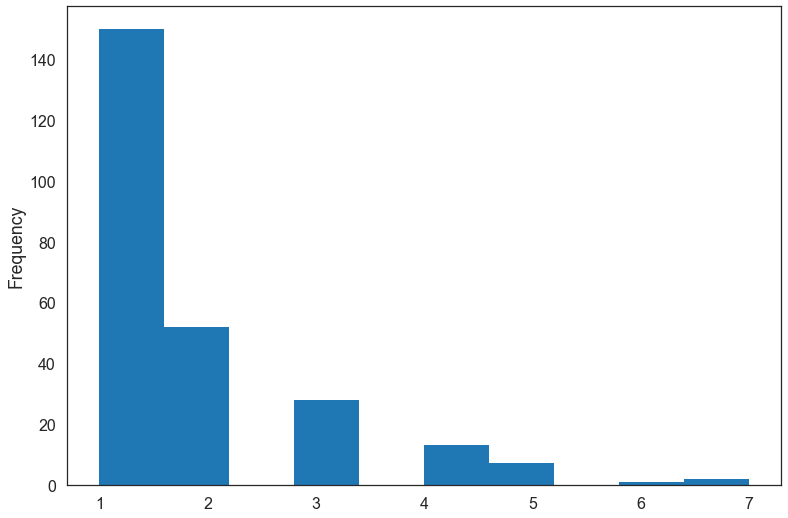

In [272]:
grp.groupby('name')['day'].count().plot(kind='hist')

In [273]:
grp.groupby('name')['day'].count().sum()

445

How many events? 

In [274]:
tmp.shape

(2049, 14)

Events per customer?

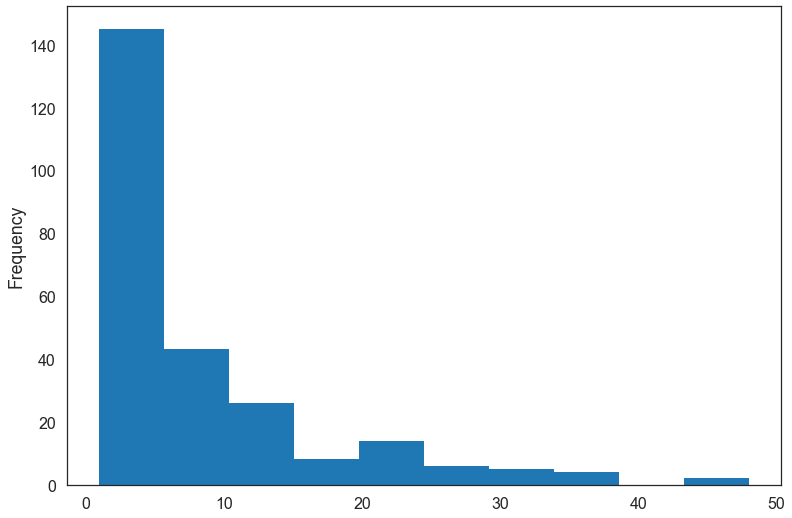

In [275]:
tmp.groupby(['name'])['value'].count().plot(kind='hist')

In [276]:
tmp.groupby(['name'])['value'].count().sum()

2049

## What is the averge % of customers impacted as a function of time of day? 

In [328]:
(tmp.groupby(['shift', 'day', 'name'])['value'].count()
     .reset_index().groupby(['shift', 'day'])
     .sum().reset_index()).pivot(index='shift', columns='day', values='value').fillna(0).head()

day,1,2,3,4,5,6,7,8,9,26,27,28,29,30,31
shift,,,,,,,,,,,,,,,
-12.933333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-12.916667,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-11.366667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
-11.350000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
-11.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [401]:
counts = tmp.pivot_table(index='shift', columns=['day', 'name'], values='value', aggfunc='count').sum(axis=1, level=0)
counts.head()

day,1,2,3,4,5,6,7,8,9,26,27,28,29,30,31
shift,,,,,,,,,,,,,,,
-12.933333,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-12.916667,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-11.366667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
-11.350000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
-11.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [402]:
counts.sum().sum()

2049.0

Events per minute.

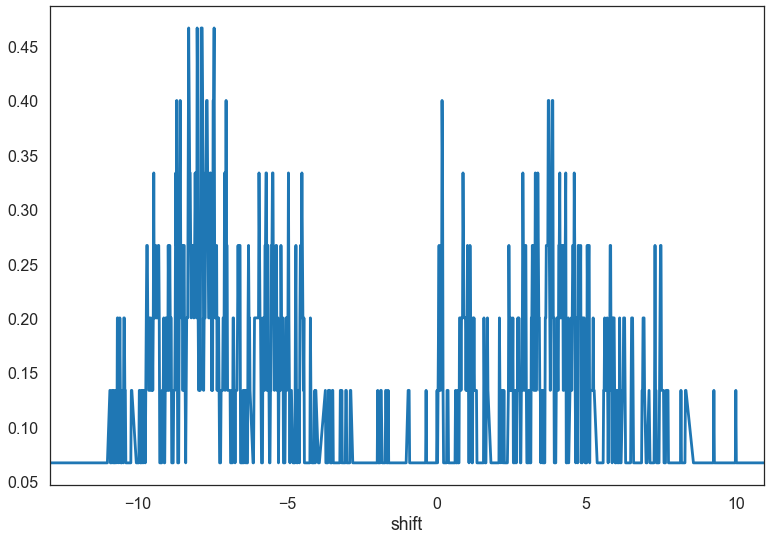

In [403]:
counts.fillna(0).mean(axis=1).plot()

Number of events every 10 minutes.

In [404]:
counts.fillna(0).mean(axis=1).sum()*15

2049.0000000000005

In [405]:
counts.shape

(954, 15)

In [406]:
import datetime
dt_index = pd.to_datetime("2013-07-01 13:00:00") + counts.index.map(lambda x: datetime.timedelta(hours=x))

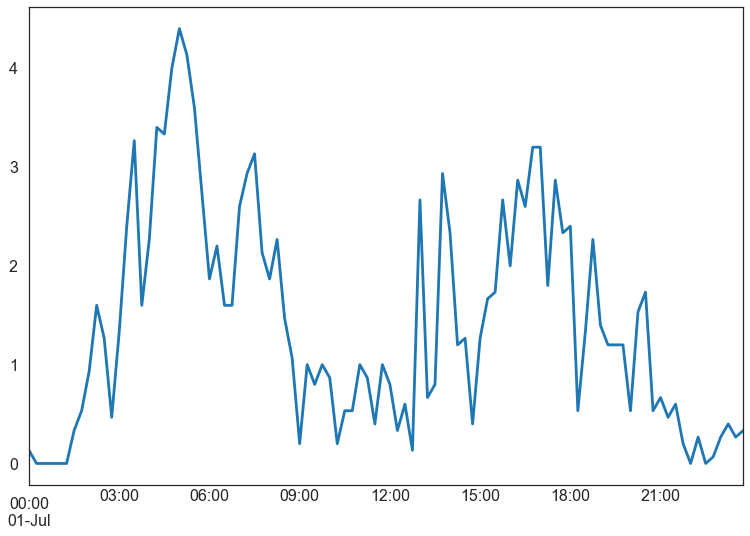

In [437]:
sample = counts.set_index(dt_index).resample('15min').sum().fillna(0)

sample.mean(axis=1).plot()

In [438]:
sample.mean(axis=1).sum()

136.60000000000002

In [439]:
sample.mean(axis=1).sum()*15

2049.0000000000005

In [424]:
sample.index = (sample.index -pd.to_datetime("2013-07-01 13:00:00")).map(lambda x: x.total_seconds()/60./60.)

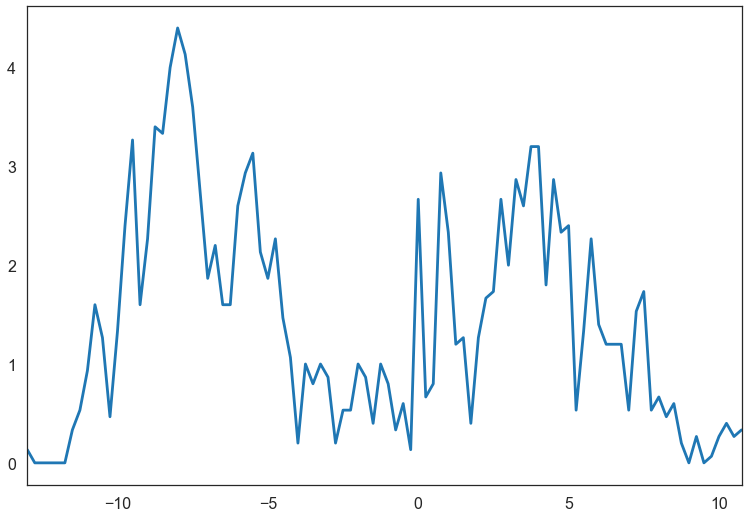

In [425]:
sample.mean(axis=1).plot()

What we did..

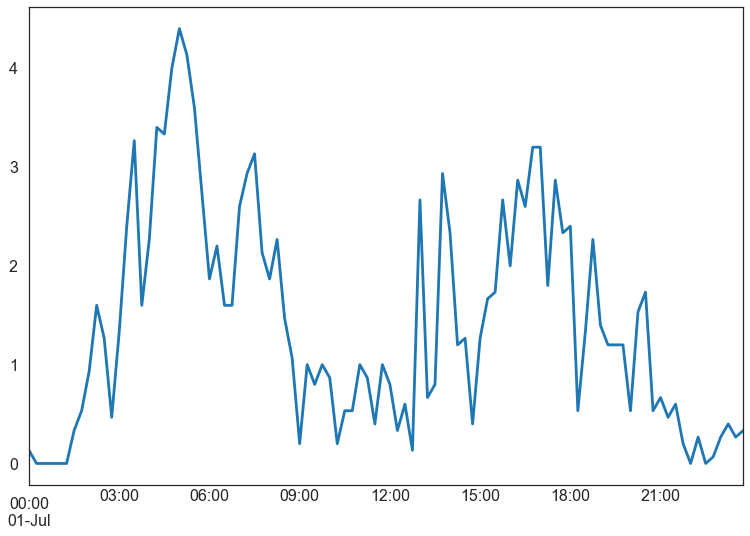

In [440]:
counts = tmp.pivot_table(index='shift', columns=['day', 'name'], values='value', aggfunc='count')
counts = counts.sum(axis=1, level=0).fillna(0)

dt_index = pd.to_datetime("2013-07-01 13:00:00") + counts.index.map(lambda x: datetime.timedelta(hours=x))
sample = counts.set_index(dt_index).resample('15min').sum().fillna(0)

sample.mean(axis=1).plot()

## Many instances 

In [441]:
qry = ["feeder=='one'",
       "season=='summer'",
       "attribute=='shower demand 110'"]

tmp = df.query(" and ".join(qry))

In [442]:
counts = tmp.pivot_table(index='shift', 
                         columns=['feeder', 'season', 'strategy', 'control', 'day', 'name'], 
                         values='value', aggfunc='count')
counts.head()

feeder                    one                                          \
season                 summer                                           
strategy           no_control                                           
control                    0                                            
day                        1                                            
name       zmq_waterheater_19 zmq_waterheater_194 zmq_waterheater_288   
shift                                                                   
-12.966667                NaN                 NaN                 NaN   
-12.950000                NaN                 NaN                 NaN   
-12.933333                NaN                 NaN                 NaN   
-12.916667                NaN                 NaN                 NaN   
-12.466667                NaN                 NaN                 NaN   

feeder                                                                  \
season                                                                   
strategy                                                                 
control                                                                  
day                                                                      
name       zmq_waterheater_393 zmq_waterheater_411 zmq_waterheater_468   
shift                                                                    
-12.966667                 NaN                 NaN                 NaN   
-12.950000                 NaN                 NaN                 NaN   
-12.933333                 NaN                 NaN                 NaN   
-12.916667                 NaN                 NaN                 NaN   
-12.466667                 NaN                 NaN                 NaN   

feeder                                                                \
season                                                                 
strategy                                                               
control                                                                
day                                                                    
name       zmq_waterheater_5 zmq_waterheater_505 zmq_waterheater_510   
shift                                                                  
-12.966667               NaN                 NaN                 NaN   
-12.950000               NaN                 NaN                 NaN   
-12.933333               NaN                 NaN                 NaN   
-12.916667               NaN                 NaN                 NaN   
-12.466667               NaN                 NaN                 NaN   

feeder                                 ...                              \
season                                 ...                               
strategy                               ...                      smooth   
control                                ...                          75   
day                                    ...                          31   
name       zmq_waterheater_561         ...         zmq_waterheater_908   
shift                                  ...                               
-12.966667                 NaN         ...                         NaN   
-12.950000                 NaN         ...                         NaN   
-12.933333                 NaN         ...                         NaN   
-12.916667                 NaN         ...                         NaN   
-12.466667                 NaN         ...                         NaN   

feeder                                                                  \
season                                                                   
strategy                                                                 
control                                                                  
day                                                                      
name       zmq_waterheater_926 zmq_waterheater_935 zmq_waterheater_937   
shift                               

In [443]:
counts = counts.sum(axis=1, level=[0,1,2,3,4]).fillna(0)
counts.head()

feeder            one                                              ...   \
season         summer                                              ...    
strategy   no_control                                              ...    
control            0                                               ...    
day                1    2    3    4    5    6    7    8    9    26 ...    
shift                                                              ...    
-12.966667        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    
-12.950000        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    
-12.933333        0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...    
-12.916667        0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...    
-12.466667        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    

feeder                                                          
season                                                          
strategy   smooth                                               
control        75                                               
day            6    7    8    9    26   27   28   29   30   31  
shift                                                           
-12.966667    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.950000    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.933333    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.916667    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.466667    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 135 columns]

In [447]:
dt_index = pd.to_datetime("2013-07-01 13:00:00") + counts.index.map(lambda x: datetime.timedelta(hours=x))
sample = counts.set_index(dt_index).resample('15min').sum().fillna(0)
sample.index = (sample.index -pd.to_datetime("2013-07-01 13:00:00")).map(lambda x: x.total_seconds()/60./60.)

In [451]:
final = sample.mean(axis=1, level=[0, 1,2,3])
final.head()

feeder          one                                                        \
season       summer                                                         
strategy no_control single_bucket                                  smooth   
control          0             6         25        50        75        6    
-13.00     0.133333      0.133333  0.133333  0.133333  0.133333  0.133333   
-12.75     0.000000      0.000000  0.000000  0.000000  0.000000  0.000000   
-12.50     0.000000      0.000000  0.000000  0.000000  0.000000  0.000000   
-12.25     0.000000      0.000000  0.000000  0.000000  0.000000  0.000000   
-12.00     0.000000      0.000000  0.000000  0.000000  0.000000  0.000000   

feeder                             
season                             
strategy                           
control         25   50        75  
-13.00    0.133333  0.2  0.266667  
-12.75    0.000000  0.0  0.000000  
-12.50    0.000000  0.0  0.133333  
-12.25    0.000000  0.0  0.000000  
-12.00    0.000000  0.0  0.000000

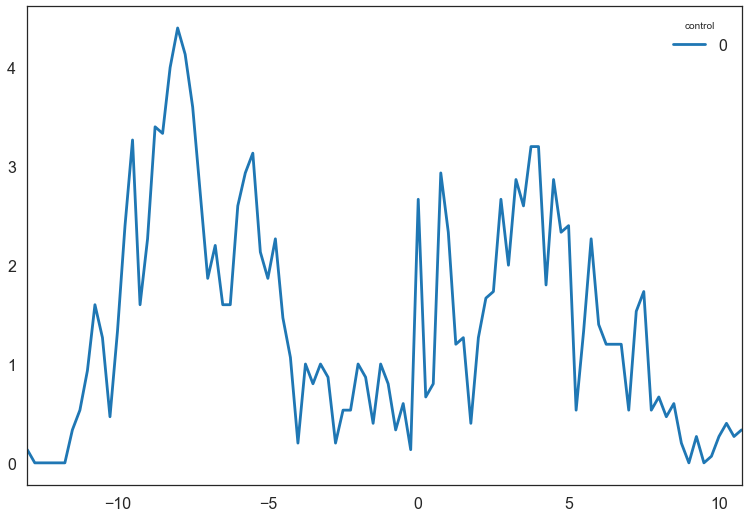

In [452]:
final[('one', 'summer', 'no_control')].plot()

Number of events every 15 minutes

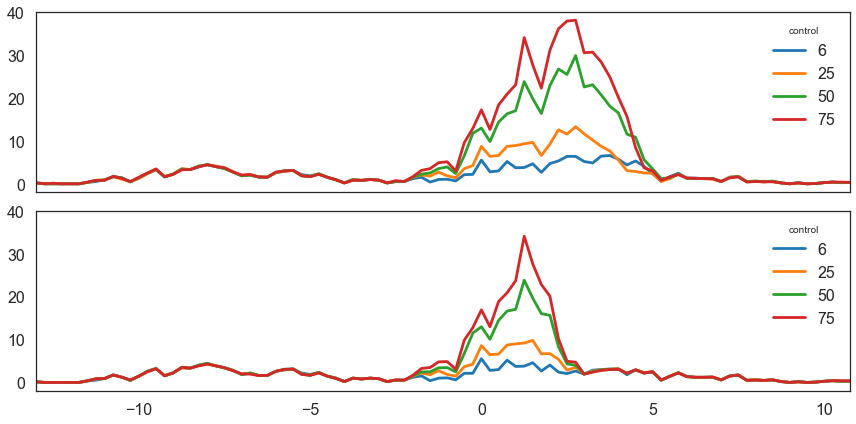

In [453]:
fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True, sharey=True)

final[('one', 'summer', 'smooth')].plot(ax=ax[0])
final[('one', 'summer', 'single_bucket')].plot(ax=ax[1])

plt.tight_layout()

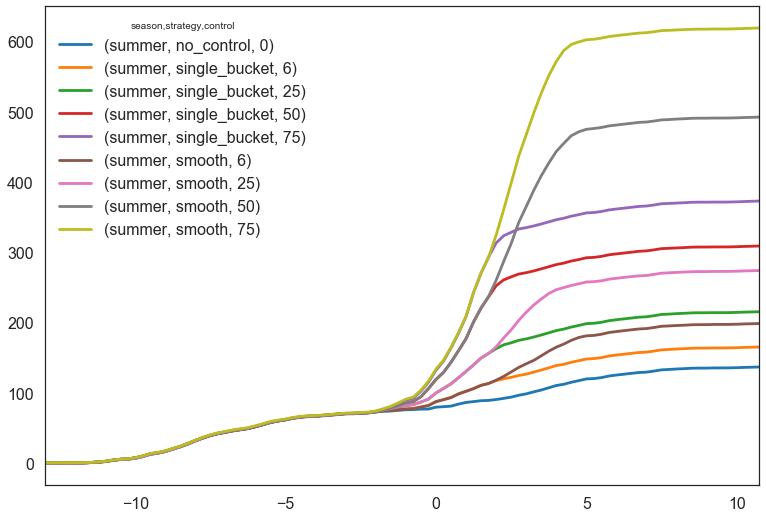

In [454]:
final['one'].cumsum().plot()

## First impact 

### Simple case 

In [455]:
qry = ["feeder=='one'",
       "season=='summer'",
       "strategy=='no_control'",
       "control==0",
       "attribute=='shower demand 110'"]

tmp = df.query(" and ".join(qry))

In [457]:
counts = tmp.pivot_table(index='shift', columns=['day', 'name'], values='value', aggfunc='count')
counts.head()

day                        1                                           \
name       zmq_waterheater_19 zmq_waterheater_194 zmq_waterheater_288   
shift                                                                   
-12.933333                NaN                 NaN                 NaN   
-12.916667                NaN                 NaN                 NaN   
-11.366667                NaN                 NaN                 NaN   
-11.350000                NaN                 NaN                 NaN   
-11.333333                NaN                 NaN                 NaN   

day                                                                     \
name       zmq_waterheater_393 zmq_waterheater_411 zmq_waterheater_468   
shift                                                                    
-12.933333                 NaN                 NaN                 NaN   
-12.916667                 NaN                 NaN                 NaN   
-11.366667                 NaN                 NaN                 NaN   
-11.350000                 NaN                 NaN                 NaN   
-11.333333                 NaN                 NaN                 NaN   

day                                                                   \
name       zmq_waterheater_5 zmq_waterheater_505 zmq_waterheater_510   
shift                                                                  
-12.933333               NaN                 NaN                 NaN   
-12.916667               NaN                 NaN                 NaN   
-11.366667               NaN                 NaN                 NaN   
-11.350000               NaN                 NaN                 NaN   
-11.333333               NaN                 NaN                 NaN   

day                                    ...                          31  \
name       zmq_waterheater_561         ...         zmq_waterheater_721   
shift                                  ...                               
-12.933333                 NaN         ...                         NaN   
-12.916667                 NaN         ...                         NaN   
-11.366667                 NaN         ...                         NaN   
-11.350000                 NaN         ...                         NaN   
-11.333333                 NaN         ...                         NaN   

day                                                                     \
name       zmq_waterheater_744 zmq_waterheater_802 zmq_waterheater_849   
shift                                                                    
-12.933333                 NaN                 NaN                 NaN   
-12.916667                 NaN                 NaN                 NaN   
-11.366667                 NaN                 NaN                 NaN   
-11.350000                 NaN                 NaN                 NaN   
-11.333333                 NaN                 NaN                 NaN   

day                                                                     \
name       zmq_waterheater_863 zmq_waterheater_876 zmq_waterheater_908   
shift                                                                    
-12.933333                 NaN                 NaN                 NaN   
-12.916667                 NaN                 NaN                 NaN   
-11.366667                 NaN                 NaN                 NaN   
-11.350000                 NaN                 NaN                 1.0   
-11.333333                 NaN                 NaN                 1.0   

day                                                                     
name       zmq_waterheater_935 zmq_waterheater_946 zmq_waterheater_971  
shift                                                                   
-12.933333                 NaN                 NaN                 NaN  
-12.916667                 NaN                 NaN                 NaN  
-11.366667                 NaN                 NaN                 NaN  
-11.350000                 N

In [458]:
import numpy as np

def fill_first_index(df):
    zeros = np.zeros(df.shape[0])
    index = df.first_valid_index()

    if index is not None:
        tmp = pd.Series(zeros, index=df.index)
        tmp.loc[tmp.index==index] = 1.0
        return tmp
    
    return pd.Series(zeros, index=df.index)

In [459]:
first = counts.apply(fill_first_index, axis=0)
first.head()

day                        1                                           \
name       zmq_waterheater_19 zmq_waterheater_194 zmq_waterheater_288   
shift                                                                   
-12.933333                0.0                 0.0                 0.0   
-12.916667                0.0                 0.0                 0.0   
-11.366667                0.0                 0.0                 0.0   
-11.350000                0.0                 0.0                 0.0   
-11.333333                0.0                 0.0                 0.0   

day                                                                     \
name       zmq_waterheater_393 zmq_waterheater_411 zmq_waterheater_468   
shift                                                                    
-12.933333                 0.0                 0.0                 0.0   
-12.916667                 0.0                 0.0                 0.0   
-11.366667                 0.0                 0.0                 0.0   
-11.350000                 0.0                 0.0                 0.0   
-11.333333                 0.0                 0.0                 0.0   

day                                                                   \
name       zmq_waterheater_5 zmq_waterheater_505 zmq_waterheater_510   
shift                                                                  
-12.933333               0.0                 0.0                 0.0   
-12.916667               0.0                 0.0                 0.0   
-11.366667               0.0                 0.0                 0.0   
-11.350000               0.0                 0.0                 0.0   
-11.333333               0.0                 0.0                 0.0   

day                                    ...                          31  \
name       zmq_waterheater_561         ...         zmq_waterheater_721   
shift                                  ...                               
-12.933333                 0.0         ...                         0.0   
-12.916667                 0.0         ...                         0.0   
-11.366667                 0.0         ...                         0.0   
-11.350000                 0.0         ...                         0.0   
-11.333333                 0.0         ...                         0.0   

day                                                                     \
name       zmq_waterheater_744 zmq_waterheater_802 zmq_waterheater_849   
shift                                                                    
-12.933333                 0.0                 0.0                 0.0   
-12.916667                 0.0                 0.0                 0.0   
-11.366667                 0.0                 0.0                 0.0   
-11.350000                 0.0                 0.0                 0.0   
-11.333333                 0.0                 0.0                 0.0   

day                                                                     \
name       zmq_waterheater_863 zmq_waterheater_876 zmq_waterheater_908   
shift                                                                    
-12.933333                 0.0                 0.0                 0.0   
-12.916667                 0.0                 0.0                 0.0   
-11.366667                 0.0                 0.0                 0.0   
-11.350000                 0.0                 0.0                 1.0   
-11.333333                 0.0                 0.0                 0.0   

day                                                                     
name       zmq_waterheater_935 zmq_waterheater_946 zmq_waterheater_971  
shift                                                                   
-12.933333                 0.0                 0.0                 0.0  
-12.916667                 0.0                 0.0                 0.0  
-11.366667                 0.0                 0.0                 0.0  
-11.350000                 0

In [488]:
first.sum(axis=0).unique()

array([ 1.])

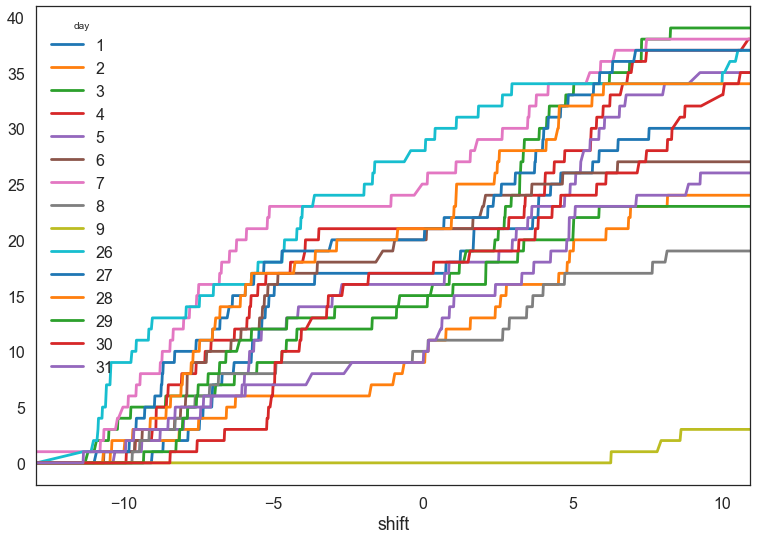

In [492]:
first.sum(axis=1, level=0).cumsum().plot()

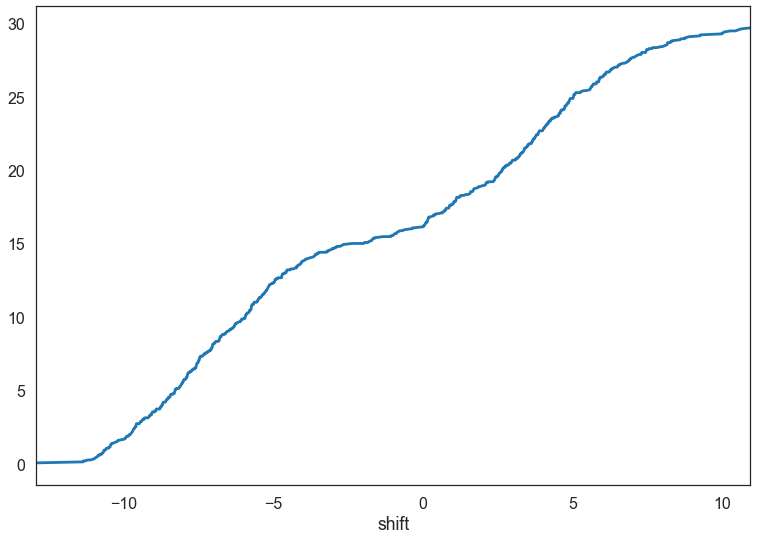

In [494]:
first.sum(axis=1, level=0).cumsum().mean(axis=1).plot()

## Multiple runs

In [497]:
qry = ["feeder=='one'",
       "season=='summer'",
       "attribute=='shower demand 110'"]

tmp = df.query(" and ".join(qry))

In [498]:
counts = tmp.pivot_table(index='shift', 
                         columns=['feeder', 'season', 'strategy', 'control', 'day', 'name'], 
                         values='value', aggfunc='count')
counts.head()

feeder                    one                                          \
season                 summer                                           
strategy           no_control                                           
control                    0                                            
day                        1                                            
name       zmq_waterheater_19 zmq_waterheater_194 zmq_waterheater_288   
shift                                                                   
-12.966667                NaN                 NaN                 NaN   
-12.950000                NaN                 NaN                 NaN   
-12.933333                NaN                 NaN                 NaN   
-12.916667                NaN                 NaN                 NaN   
-12.466667                NaN                 NaN                 NaN   

feeder                                                                  \
season                                                                   
strategy                                                                 
control                                                                  
day                                                                      
name       zmq_waterheater_393 zmq_waterheater_411 zmq_waterheater_468   
shift                                                                    
-12.966667                 NaN                 NaN                 NaN   
-12.950000                 NaN                 NaN                 NaN   
-12.933333                 NaN                 NaN                 NaN   
-12.916667                 NaN                 NaN                 NaN   
-12.466667                 NaN                 NaN                 NaN   

feeder                                                                \
season                                                                 
strategy                                                               
control                                                                
day                                                                    
name       zmq_waterheater_5 zmq_waterheater_505 zmq_waterheater_510   
shift                                                                  
-12.966667               NaN                 NaN                 NaN   
-12.950000               NaN                 NaN                 NaN   
-12.933333               NaN                 NaN                 NaN   
-12.916667               NaN                 NaN                 NaN   
-12.466667               NaN                 NaN                 NaN   

feeder                                 ...                              \
season                                 ...                               
strategy                               ...                      smooth   
control                                ...                          75   
day                                    ...                          31   
name       zmq_waterheater_561         ...         zmq_waterheater_908   
shift                                  ...                               
-12.966667                 NaN         ...                         NaN   
-12.950000                 NaN         ...                         NaN   
-12.933333                 NaN         ...                         NaN   
-12.916667                 NaN         ...                         NaN   
-12.466667                 NaN         ...                         NaN   

feeder                                                                  \
season                                                                   
strategy                                                                 
control                                                                  
day                                                                      
name       zmq_waterheater_926 zmq_waterheater_935 zmq_waterheater_937   
shift                               

In [499]:
first = counts.apply(fill_first_index, axis=0)
first.head()

feeder                    one                                          \
season                 summer                                           
strategy           no_control                                           
control                    0                                            
day                        1                                            
name       zmq_waterheater_19 zmq_waterheater_194 zmq_waterheater_288   
shift                                                                   
-12.966667                0.0                 0.0                 0.0   
-12.950000                0.0                 0.0                 0.0   
-12.933333                0.0                 0.0                 0.0   
-12.916667                0.0                 0.0                 0.0   
-12.466667                0.0                 0.0                 0.0   

feeder                                                                  \
season                                                                   
strategy                                                                 
control                                                                  
day                                                                      
name       zmq_waterheater_393 zmq_waterheater_411 zmq_waterheater_468   
shift                                                                    
-12.966667                 0.0                 0.0                 0.0   
-12.950000                 0.0                 0.0                 0.0   
-12.933333                 0.0                 0.0                 0.0   
-12.916667                 0.0                 0.0                 0.0   
-12.466667                 0.0                 0.0                 0.0   

feeder                                                                \
season                                                                 
strategy                                                               
control                                                                
day                                                                    
name       zmq_waterheater_5 zmq_waterheater_505 zmq_waterheater_510   
shift                                                                  
-12.966667               0.0                 0.0                 0.0   
-12.950000               0.0                 0.0                 0.0   
-12.933333               0.0                 0.0                 0.0   
-12.916667               0.0                 0.0                 0.0   
-12.466667               0.0                 0.0                 0.0   

feeder                                 ...                              \
season                                 ...                               
strategy                               ...                      smooth   
control                                ...                          75   
day                                    ...                          31   
name       zmq_waterheater_561         ...         zmq_waterheater_908   
shift                                  ...                               
-12.966667                 0.0         ...                         0.0   
-12.950000                 0.0         ...                         0.0   
-12.933333                 0.0         ...                         0.0   
-12.916667                 0.0         ...                         0.0   
-12.466667                 0.0         ...                         0.0   

feeder                                                                  \
season                                                                   
strategy                                                                 
control                                                                  
day                                                                      
name       zmq_waterheater_926 zmq_waterheater_935 zmq_waterheater_937   
shift                               

In [502]:
first.sum(axis=1, level=[0,1,2,3,4]).cumsum().head()

feeder            one                                              ...   \
season         summer                                              ...    
strategy   no_control                                              ...    
control            0                                               ...    
day                1    2    3    4    5    6    7    8    9    26 ...    
shift                                                              ...    
-12.966667        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    
-12.950000        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...    
-12.933333        0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...    
-12.916667        0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...    
-12.466667        0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0 ...    

feeder                                                          
season                                                          
strategy   smooth                                               
control        75                                               
day            6    7    8    9    26   27   28   29   30   31  
shift                                                           
-12.966667    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.950000    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.933333    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.916667    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
-12.466667    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 135 columns]

In [504]:
final = first.sum(axis=1, level=[0,1,2,3,4]).cumsum().mean(axis=1, level=[0,1,2,3])

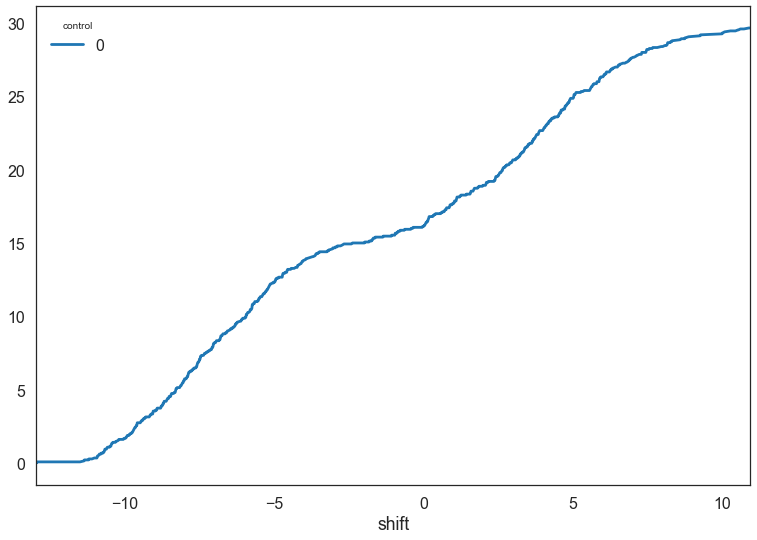

In [506]:
final[('one', 'summer', 'no_control')].plot()

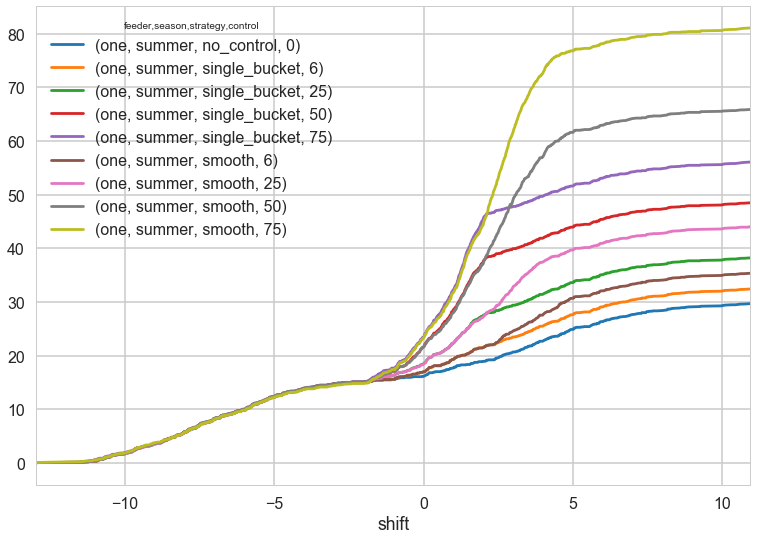

In [508]:
plt.style.use("seaborn-whitegrid")
final.plot()

In [515]:
stack = pd.melt(final.reset_index(), id_vars=['shift'])
stack.head()

,shift,feeder,season,strategy,control,value
0,-12.966667,one,summer,no_control,0,0.000000
1,-12.950000,one,summer,no_control,0,0.000000
2,-12.933333,one,summer,no_control,0,0.066667
3,-12.916667,one,summer,no_control,0,0.066667
4,-12.466667,one,summer,no_control,0,0.066667


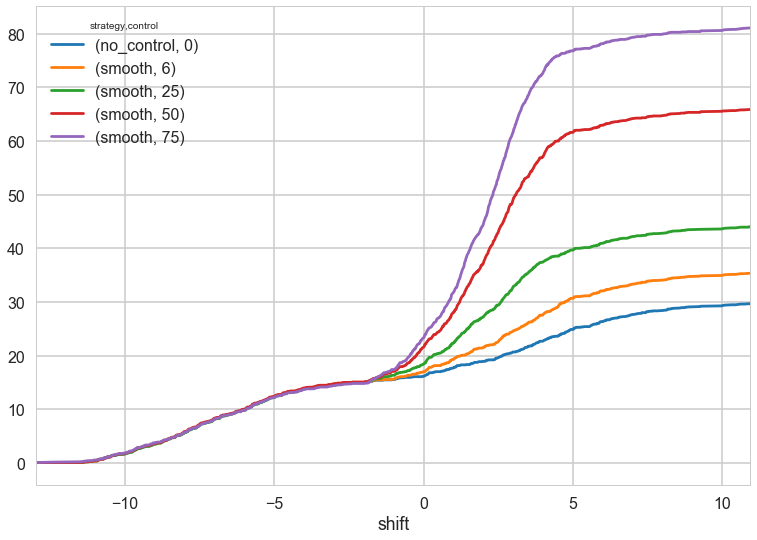

In [519]:
(stack.query("strategy in ['no_control', 'smooth']")
      .pivot_table(index='shift', columns=['strategy', 'control'], values='value')).plot()